# Introduction and overview

For given diffusivity $D(x)$, drift $a(x)$, reference path $\varphi(t)$, and tube radius $R(t)$, 
the module **PyTubular** allows to perturbatively evaluate 

* the exit rate along the tube,
* the normalized probability density within the tube.

We here demonstrate these features of **PyTubular** for an example system. We compare the analytical perturbative exit rate, and perturbative normalized probability density inside the tube, to the corresponding results from direct numerical simulations of the Fokker-Planck equation.

To simulate the Fokker-Planck directly we use the python module fokker_planck, which can be downloaded here: https://github.com/juliankappler/fokker-planck

In [1]:
# imports of standard modules used
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import cumtrapz

# we change some plotting parameters, for more pretty plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='7'
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25) 
mpl.rcParams.update({'font.size': 25})
mpl.rcParams.update({'legend.fontsize': 15})

## Create instance of PyTubular.symbolic class

In [2]:
import PyTubular

In [3]:
pt = PyTubular.symbolic()

# creating an instance of the PyTubular.analytical() class
# defines the following symbolic variables:
L = pt.L # length scale
T = pt.T # time scale
D0 = pt.D0 # diffusivity scale = L^2/T
#
x = pt.x # spatial coordinate
t = pt.t # temporal coordinate

# note that by definition, \tau_D = T

## Define drift and diffusivity

In [4]:
# Drift a
# Note that the drift needs to have units L/T

a0 = 2.*L**2/T

U = a0 * ( (x/L)**2 - 1 ) **2  # double well potential
a = -sp.diff(U,x,1) # drift = -grad(potential)

a 

-8.0*x*(-1 + x**2/L**2)/T

In [5]:
# Diffusivity D
# Note that the diffusivity has to have units D0 = L^2/T

D = D0 * sp.Rational(1,4)*(5-sp.cos(sp.pi* x/L))

D

L**2*(5 - cos(pi*x/L))/(4*T)

## Define reference path

In [6]:
x_0 = -0.99626 * L # starting position of path
x_1 =  1.00366 * L # ending position of path
# These are the minima of the steady-state potential pertaining to 
# the drift and diffusivity we use

kappa = 10 # parameter determines maximal barrier-crossing speed of path

path = (x_0 + x_1)/2  \
       + (x_1-x_0)/2/sp.atan(kappa/2) * sp.atan(kappa*(t/T-1/2))

path

-0.728090462789172*L*atan(5.0 - 10*t/T) + 0.00369999999999998*L

## Define tube radius

In [7]:
R = 0.3 * L # constant radius, i.e. independent of time

R

0.3*L

## Pass drift, diffusivity, path, and radius to PyTubular.symbolic instance

In [8]:
# We pass all the analytical expressions, which use the units L, T defined 
# by our instance pt = PyTubular.analytical()
pt.set_a(a=a)
pt.set_D(D=D)
pt.set_path(path=path)
pt.set_R(R=R)

## Plot diffusivity, potential, and tube

In [9]:
# For plotting, we convert the analytically defined expressions 
# into numerical functions

# a_function takes the position in units of L, and returns the drift
# in units of L/T
a_function = np.vectorize(
                sp.lambdify(x, 
                            sp.expand(a.subs(x,x*L)*T/L)
                        ))

# D_function takes the position in units of L, and returns the diffusivity
# in units of D0 = L**2/T
D_function = np.vectorize(
                sp.lambdify(x, 
                            sp.expand(D.subs(x,x*L)/D0)
                        ))

# path_function takes the time in units of T, and returns the path position
# in units of L
path_function = np.vectorize(
                sp.lambdify(t, 
                            sp.expand(path.subs(t,t*T)/L)
                        ))

# R_function takes the time in units of T, and returns the tube radius
# in units of L
R_function = np.vectorize(
                sp.lambdify(t, 
                            sp.expand(R.subs(t,t*T)/L)
                        ))

In [10]:
x_eval = np.linspace(-1.4,1.4,  # spatial plotting range
                        endpoint=True,num=1001) 
t_eval = np.linspace(0, 1,    # temporal plotting range
                        endpoint=True,num=1001)

D_eval = D_function(x_eval)
a_eval = a_function(x_eval)
path_eval = path_function(t_eval)
R_eval = R_function(t_eval)

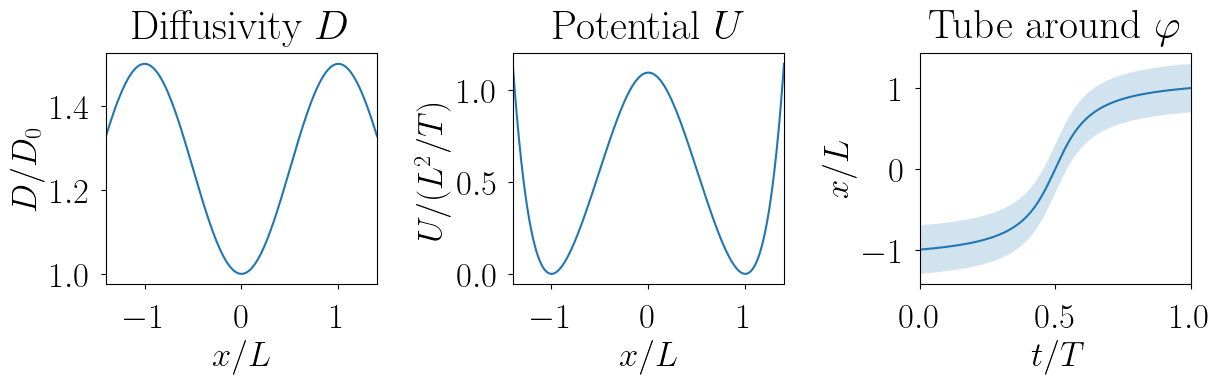

In [11]:
fig,axes = plt.subplots(1,3,figsize=(14,3))
fig.subplots_adjust(wspace=0.5)

# left subplot: Diffusivity profile
ax = axes[0]
ax.plot(x_eval,D_eval)
ax.set_xlim(np.min(x_eval),np.max(x_eval))
ax.set_title(r'Diffusivity $D$',y=1.03)
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$D/D_0$')

# middle subplot: Steady-state potential
ax = axes[1]
# We first need to calculate the steady state:
U_eval = -cumtrapz(y=a_eval/D_eval,
                x=x_eval,
                initial=0)
U_eval += D_eval
U_eval -= np.min(U_eval)
ax.plot(x_eval,U_eval)
ax.set_xlim(np.min(x_eval),np.max(x_eval))
ax.set_title(r'Potential $U$',y=1.03)
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$U/(L^2/T)$')

# right subplot: Reference path + tube
ax = axes[2]
ax.fill_between(t_eval,
        path_eval-R_eval,
        path_eval+R_eval,
               alpha=0.2)
ax.plot(t_eval,
        path_eval)
ax.set_xlim(np.min(t_eval),np.max(t_eval))
ax.set_title(r'Tube around $\varphi$',y=1.03)
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$x/L$')

plt.show()
plt.close(fig)

## Evaluate perturbative analytical exit rate

In [12]:
order = 2 # means we evaluate the perturbation series up to including
# quadratic order beyond the free-diffusion solution. So our perturbation 
# series contains the terms at orders 1/R^2, 1/R, R^0, with the 1/R term 
# vanishing anyways.

exit_rate_analytical = pt.eval_exit_rate(
                    t=t_eval,
                    order=order, 
                    powers_separate=False, # return summed perturbation series
                    full_output=True,
                    )

In [13]:
exit_rate_analytical.keys()

dict_keys(['t', 'epsilon', 'exit_rate'])

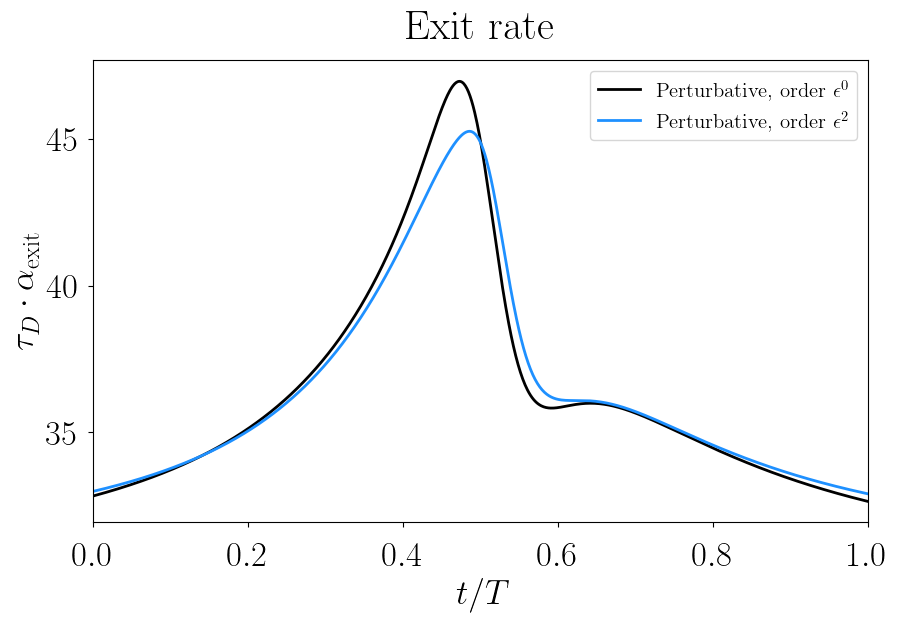

In [14]:
# For plotting, we want to compare the exit rate to order R^0 and to order R^2

fig,ax = plt.subplots(1,1,figsize=(10,6))

orders = [2,4]
linestyles = {2:'-',4:'-'}
colors={2:'black',4:'dodgerblue'}
lw=2
for order in orders:
    exit_rate = pt.eval_exit_rate(t=t_eval,order = order)
    ax.plot(t_eval,exit_rate['exit_rate'],
           label='Perturbative, order $\epsilon^{{{0}}}$'.format(order-2),
            lw=lw,
            color=colors[order],
           ls=linestyles[order])

ax.set_xlim(np.min(t_eval),np.max(t_eval))
ax.legend(loc='best')
ax.set_title(r'Exit rate',y=1.03)
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$\tau_D \cdot \alpha_{\mathrm{exit}}$')

plt.show()
plt.close(fig)

We observe that at the tube radius we consider, the quadratic terms are non-negligible.

## Compare analytical perturbative solution to results from numerical simulation

In [15]:
# For the apparent drift, we need the temporal derivatives of the path- and 
# the radius function

# dot_path_function takes the time in units of T, and returns the temporal 
# derivative of the path (i.e. the path velocity) in units of L/T
dot_path = sp.diff(path,t)
dot_path_function = np.vectorize(
                sp.lambdify(t, 
                            sp.expand(dot_path.subs(t,t*T)/L*T)
                        ))

# dR_function takes the time in units of T, and returns the temporal derivative
# of the tube radius in units of L/T
dR = sp.diff(R,t)
dR_function = np.vectorize(
                sp.lambdify(t, 
                            sp.expand(dR.subs(t,t*T)/L*T)
                        ))

In [16]:
def a_FP(x,t): # we later insert an array for x
    '''
    Returns the dimensionless force.
    Assumes both t and x are in dimensionless form
    ''';
    x_with_dimensions = path_function(t) + R_function(t)*x # in units of L
    #
    # note that
    # a_app(x,t) = tD/L ( a(x,t) - dot_path(t) ) - dot_epsilon * xDL
    return ( (a_function(x_with_dimensions) \
                    - dot_path_function(t))  \
                    - dR_function(t) ) / R_function(t)

def D_FP(x,t):
    '''
    Returns the dimensionless diffusivity divided by epsilon^2

    By definition of the Stratonovich coordinate transformation,
    the diffusivity is constant in the new coordinate system, and equal to unity
    '''
    x_with_dimensions = path_function(t) + R_function(t)*x # in units of L
    #
    return D_function(x_with_dimensions)/R_function(t)**2


In [17]:
# spatial parameters
# spatial domain is [xl,xr]
xl = -1
xr = 1.
Nx = 101 # number of points in (xl,xr) for spatial discretization

# temporal parameters
dt = 1e-6 # timestep
Nt = 1e6 # number of timesteps for simulation
# total simulated time is T = Nt * dt
saving_stride = 100

# Define quantities with dimensions
#L = 1. # unit of length
#D0 = 1. # L^2/T # unit of diffusion
#tD = L**2/D0

parameters = {# spatial parameters
              'xl':xl,
              'xr':xr,
              'Nx':Nx,
              # temporal parameters
             'Nt':Nt,
             'dt':dt,
             'saving_stride':saving_stride,
             }

import fokker_planck
# instantiate class
simulation = fokker_planck.numerical(parameters)

In [18]:
P0 = np.zeros(Nx,dtype=float) # initial condition
P0[Nx//4:3*Nx//4] = 1. # uniform distribution at the center of the interval [xl,xr]

simulation_results = simulation.forward_euler(D=D_FP,
                a=a_FP,P0=P0) # run simulation

Found time-dependent diffusivity function D(x,t)
Found time-dependent drift function a(x,t)
Running simulation. Progress: 100%, elapsed time: 0:01:48, remaining time: 0:00:00			


In [19]:
simulation_results.keys()

dict_keys(['t', 'x', 'y', 'dx', 'Nx', 'dt', 'Nt', 'xl', 'xr', 'saving_stride', 'boundary_condition_left', 'boundary_condition_right'])

In [20]:
exit_rate_numerical = simulation.get_exit_rate(result=simulation_results)

exit_rate_numerical.keys()

dict_keys(['integrals', 'exit_rate', 't'])

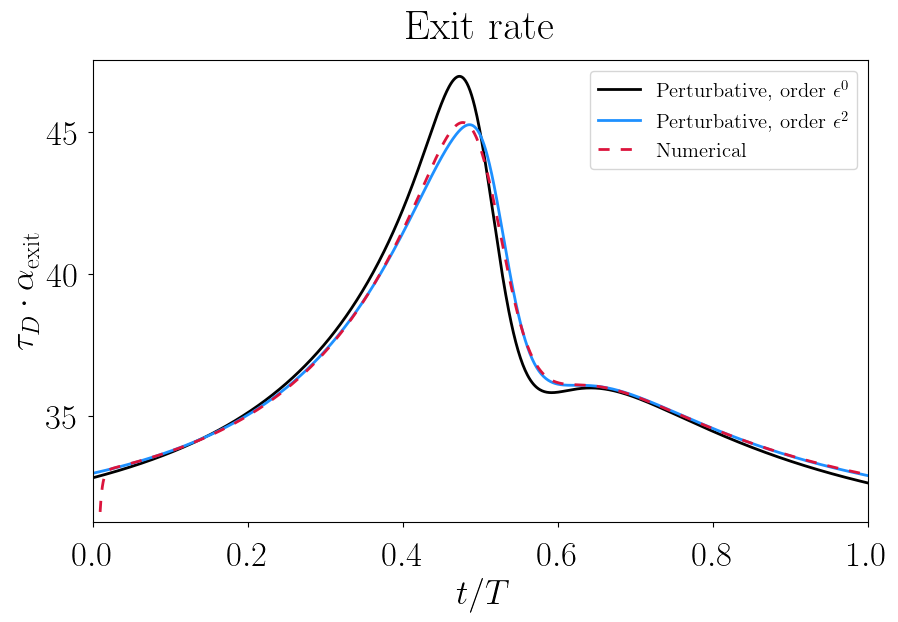

In [21]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

orders = [2,4]
linestyles = {2:'-',4:'-'}
colors={2:'black',4:'dodgerblue'}
lw=2
for order in orders:
        exit_rate = pt.eval_exit_rate(t=t_eval,order = order)
        ax.plot(t_eval,exit_rate['exit_rate'],
                label='Perturbative, order $\epsilon^{{{0}}}$'.format(order-2),
                lw=lw,
                color=colors[order],
                ls=linestyles[order])
        ax.set_ylim(0.95*np.min(exit_rate['exit_rate']),
                        1.05*np.max(exit_rate['exit_rate']))

ax.plot(exit_rate_numerical['t'],
        exit_rate_numerical['exit_rate'],
        label='Numerical',
        lw=lw,
        color='crimson',
        dashes=[4,4])

ax.set_xlim(np.min(t_eval),np.max(t_eval))
ax.legend(loc='best')
ax.set_title(r'Exit rate',y=1.03)
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$\tau_D \cdot \alpha_{\mathrm{exit}}$')

plt.show()
plt.close(fig)

The perturbative exit rate to including order $R^2$ shows reasonable agreement with the exit rate from direct simulation.

## Normalized probability density in tube

We now plot the normalized density of the survivor positions inside the tube for various times.

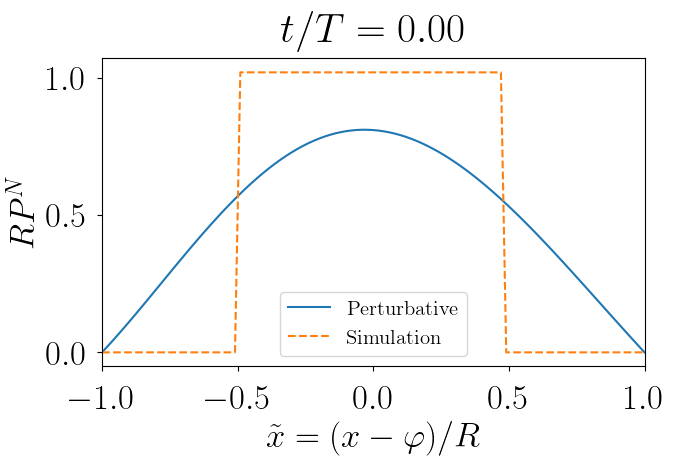

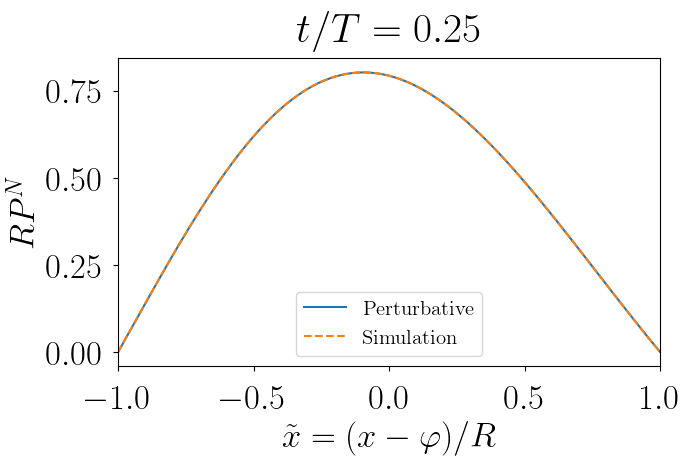

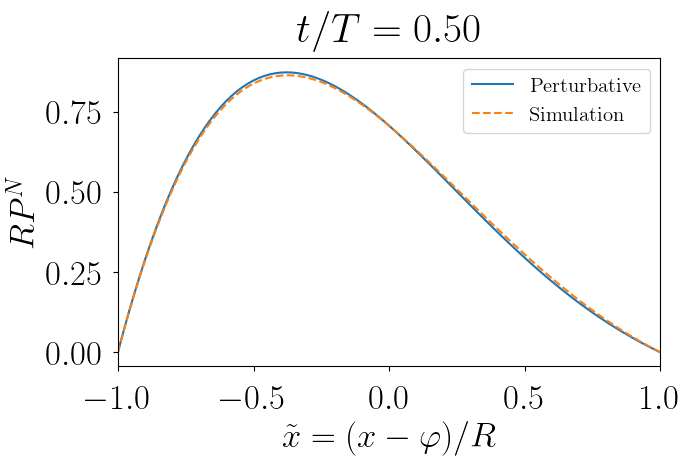

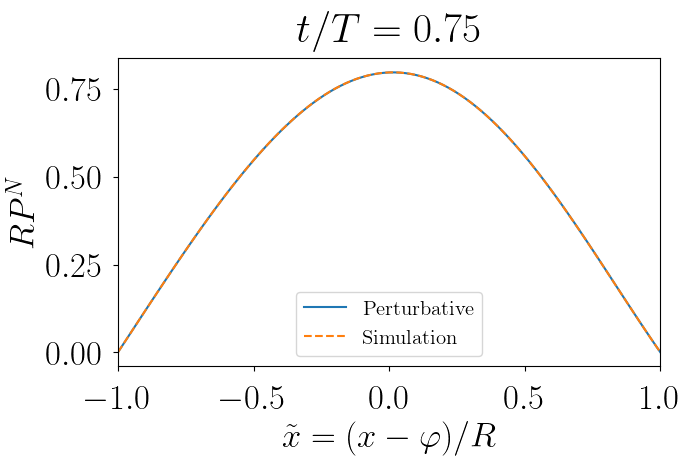

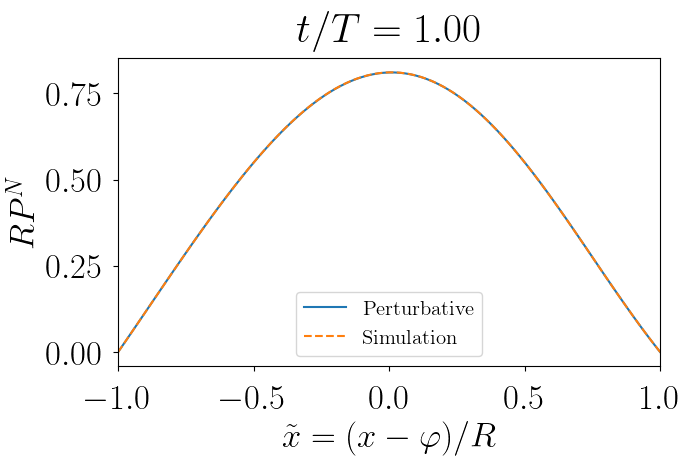

In [22]:
N_plot = 4

stride_plot = len(simulation_results['t'])//N_plot
tP = simulation_results['t'][::stride_plot]
P = simulation_results['y'][::stride_plot]
xDL = simulation_results['x']

normalized_density_dict = pt.eval_normalized_density(t=tP,
                                                     full_output=True)
xP = normalized_density_dict['x']


for i,e in enumerate(P):
    fig,ax = plt.subplots(1,1,figsize=(7,4))
    ax.plot(xP,normalized_density_dict['normalized_density'][i],
           label='Perturbative')
    ax.plot(xDL,e/np.trapz(e,xDL),ls='--',
           label='Simulation')
    #
    ax.set_xlim(np.min(xP),np.max(xP))
    ax.set_title(r'$t/T = {0:3.2f}$'.format(tP[i]),y=1.03)
    ax.legend(loc='best')
    ax.set_xlabel(r'$\tilde{x} = (x-\varphi)/R$')
    ax.set_ylabel(r'$R P^{N}$')
    #
    plt.show()
    plt.close(fig)

At time $t = 0$ we can clearly see the initial conditions of the simulation.